In [1]:
import sys
sys.path.append('../src/')
import os
import re
import nibabel as nib
import numpy as np
import scipy
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from finetune_3D import *
from logistic_regression import *
from models import *

In [3]:
def load_experiment(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    df.train_BA = df.train_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.train_auroc = df.train_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_BA = df.val_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_auroc = df.val_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_BA = df.test_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_auroc = df.test_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    return df

In [4]:
def split_df(df, index):
    X_train = torch.Tensor(df[df.n<=360]['n'].to_numpy())
    y_train = torch.Tensor(np.array(df[df.n<=360]['test_auroc'].to_list())[:,index])
    X_test = torch.Tensor(df[df.n>360]['n'].to_numpy())
    y_test = torch.Tensor(np.array(df[df.n>360]['test_auroc'].to_list())[:,index])
    return X_train, y_train, X_test, y_test

def train_GP(X, y, training_iter=10000):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.train()
    model = GPPowerLaw(X, y, likelihood)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
    return likelihood, model

def train_model(X, y, training_iter=10000):
    model = PowerLaw()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_func = nn.MSELoss()
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    return model

In [5]:
# cbi lr=0.1, sbi lr=0.01
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3/n=600_random_state=1001.csv')
print(open('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3/n=600_random_state=1001.txt').read())
df.tail()

{'wd1': 0.001, 'wd2': 0}



,epoch,train_loss,train_BA,train_auroc,val_loss,val_BA,val_auroc,test_loss,test_BA,test_auroc
995,996,0.451877,[0.79962713],[0.88381126],0.505643,[0.72077922],[0.71192444],0.510975,[0.71604938],[0.67901235]
996,997,0.451829,[0.80060369],[0.88396662],0.505639,[0.72077922],[0.71192444],0.510986,[0.71604938],[0.67798354]
997,998,0.451782,[0.80060369],[0.88407759],0.505634,[0.72077922],[0.71192444],0.510997,[0.71604938],[0.67798354]
998,999,0.451734,[0.80060369],[0.88425515],0.505630,[0.72077922],[0.71192444],0.511008,[0.71604938],[0.67798354]
999,1000,0.451687,[0.80060369],[0.88434393],0.505625,[0.72077922],[0.71192444],0.511019,[0.71604938],[0.67798354]


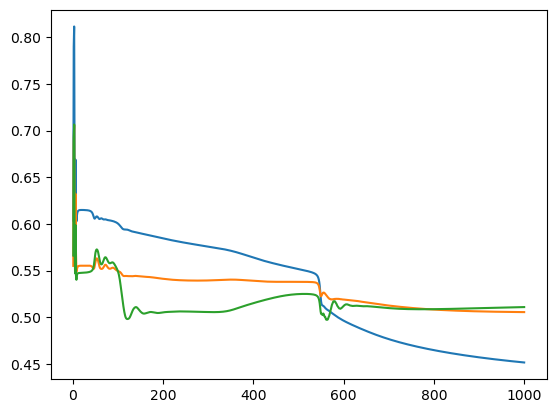

In [6]:
plt.plot(df.epoch.to_list(), df.train_loss.to_list())
plt.plot(df.epoch.to_list(), df.val_loss.to_list())
plt.plot(df.epoch.to_list(), df.test_loss.to_list())

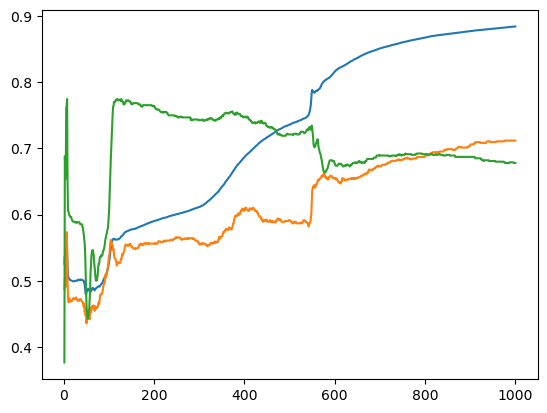

In [7]:
plt.plot(df.epoch.to_list(), np.array(df.train_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.val_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.test_auroc.to_list())[:,0])

In [8]:
val_performance = np.sum(np.array(df.val_auroc.to_list()), axis=-1)
averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
print(30+np.argmax(averaged_performance))
print(df.test_auroc.to_list()[30+np.argmax(averaged_performance)])

999
[0.67798354]


In [15]:
columns = ['n', 'random_state', 'train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']
df = pd.DataFrame(columns=columns)

ns = [200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600]
random_states = [2001, 3001]

for model_index, (n, random_state) in enumerate(itertools.product(ns, random_states)):
    print(open('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3/n={}_random_state={}.txt'\
               .format(n, random_state)).read())
    
    temp_df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3/n={}_random_state={}.csv'\
                         .format(n, random_state))
    val_performance = np.sum(np.array(temp_df.val_auroc.to_list()), axis=-1)
    averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
    print(30+np.argmax(averaged_performance))
    train_loss, train_BA, train_auroc, val_loss, val_BA, val_auroc, test_loss, test_BA, test_auroc = temp_df.iloc[30+np.argmax(averaged_performance)].to_list()[1:]
    row = [n, random_state, train_BA, train_auroc, val_BA, val_auroc, test_BA, test_auroc]
    df.loc[model_index] = row

{'wd1': 0.001, 'wd2': 0.1}

999
{'wd1': 1.0, 'wd2': 0.0001}

477
{'wd1': 0.01, 'wd2': 1.0}

622
{'wd1': 1.0, 'wd2': 0.001}

170
{'wd1': 0.001, 'wd2': 1.0}

971
{'wd1': 0.1, 'wd2': 0.1}

509
{'wd1': 0.001, 'wd2': 1.0}

989
{'wd1': 0.1, 'wd2': 0.1}

112
{'wd1': 0.001, 'wd2': 1.0}

998
{'wd1': 1.0, 'wd2': 0.0001}

487
{'wd1': 0.001, 'wd2': 1.0}

970
{'wd1': 0.1, 'wd2': 0.001}

549
{'wd1': 0.001, 'wd2': 0.1}

884
{'wd1': 0.1, 'wd2': 0.01}

415
{'wd1': 0.001, 'wd2': 0.1}

850
{'wd1': 0.1, 'wd2': 1.0}

162
{'wd1': 0.001, 'wd2': 0.1}

898
{'wd1': 0.1, 'wd2': 0.01}

704
{'wd1': 0.01, 'wd2': 0.1}

638
{'wd1': 0.1, 'wd2': 0.1}

294
{'wd1': 0.01, 'wd2': 0.01}

603
{'wd1': 1.0, 'wd2': 0.1}

807


In [16]:
df

,n,random_state,train_BA,train_auroc,val_BA,val_auroc,test_BA,test_auroc
0,200,2001,[0.93786982],[0.96697843],[0.76470588],[0.76348039],[0.61829837],[0.67599068]
1,200,3001,[0.63731061],[0.64204545],[0.69131455],[0.63380282],[0.54268293],[0.59908537]
2,240,2001,[0.83181344],[0.89747264],[0.83333333],[0.79166667],[0.57983683],[0.61538462]
3,240,3001,[0.61354447],[0.60983827],[0.67723005],[0.62323944],[0.4992378],[0.60137195]
4,280,2001,[0.8733196],[0.93445197],[0.78186275],[0.74142157],[0.61888112],[0.67948718]
5,280,3001,[0.69169427],[0.75377254],[0.66255869],[0.66314554],[0.64481707],[0.60442073]
6,320,2001,[0.88541667],[0.93321078],[0.75490196],[0.76593137],[0.56701632],[0.64918415]
7,320,3001,[0.69531892],[0.73811479],[0.68485915],[0.70539906],[0.53582317],[0.625]
8,360,2001,[0.84259259],[0.91055435],[0.7622549],[0.7622549],[0.57983683],[0.65501166]
9,360,3001,[0.58300019],[0.59692874],[0.68485915],[0.67605634],[0.5160061],[0.52439024]


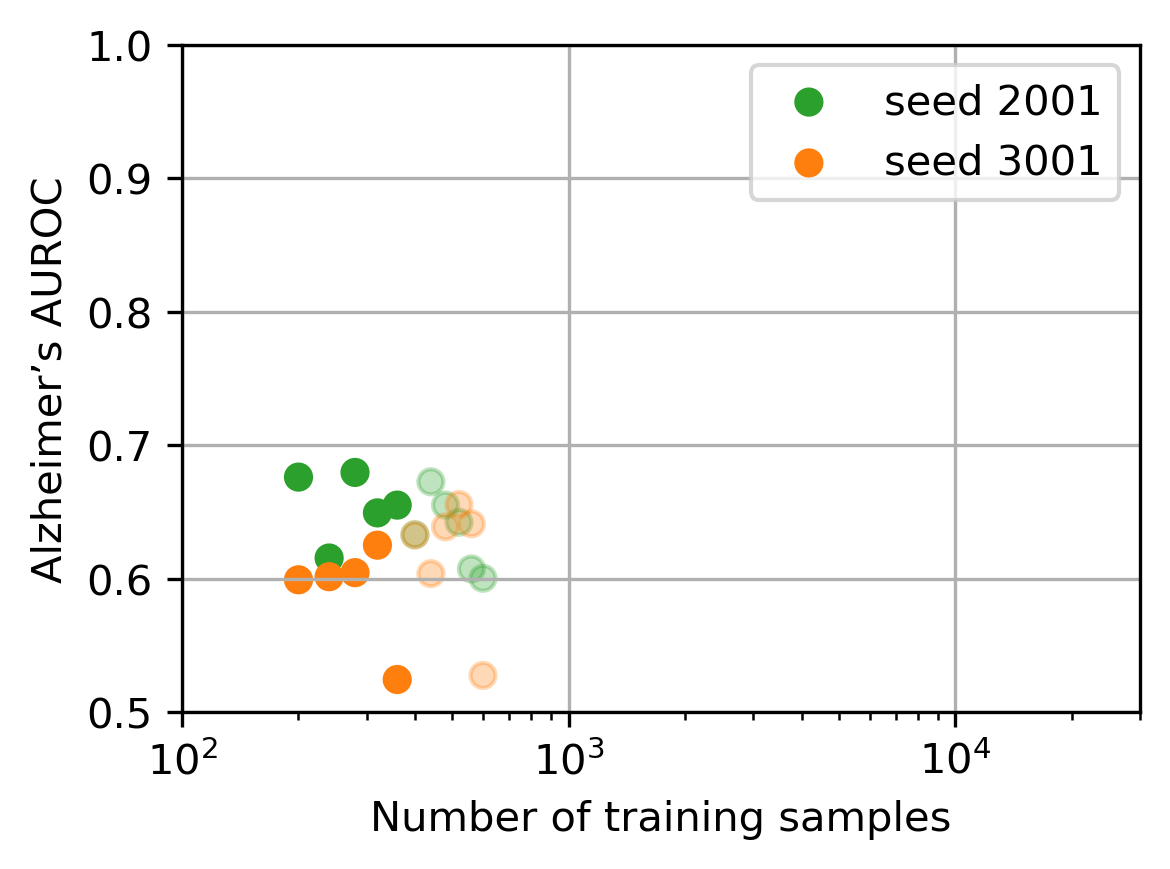

In [17]:
def get_alpha(n):
    if n <= 360:
        return 1.0
    else:
        return 0.3

def plot_experiment(df, labels, random_states=[1001, 2001, 3001]):
    df = df[df.random_state.isin(random_states)]
    colors = ['#2ca02c','#ff7f0e', '#9467bd']
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
    for label_index, _ in enumerate(labels):
        # Train model
        """
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        model = train_model(X_train, y_train)
        model.eval()
        with torch.no_grad():
            observed_pred = model(torch.linspace(100, 30000, 1000))
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.numpy(), color='#d62728', label='Power law')

        X_train, y_train, X_test, y_test = split_df(df, label_index)
        likelihood, model = train_GP(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        upper = observed_pred.mean.numpy()+(3*observed_pred.stddev.numpy())
        lower = observed_pred.mean.numpy()-(3*observed_pred.stddev.numpy())
        observed_pred.mean.numpy()
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Gaussian process (ours)')
        np.array(axs).flatten()[label_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        """        
        for color, random_state in zip(colors, random_states):
            # Plot data
            temp_df = df[df.random_state==random_state]
            np.array(axs).flatten()[label_index]\
            .scatter(temp_df.n.to_numpy(),
                     np.array(temp_df.test_auroc.to_list())[:,label_index],
                     color = color,
                     alpha=list(map(get_alpha, df.n[df.random_state==random_state].to_list())),
                     label='seed {}'.format(random_state))
        np.array(axs).flatten()[label_index]\
        .set_xlim([100, 30000])
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    fig.tight_layout()
    plt.show()
    
#df = df.groupby('n').agg(lambda x: list(x))
#df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
#df.random_state = df.random_state.apply(lambda x: 'mean')
#df = df.reset_index()
#plot_experiment(df, ['Alzheimer’s'], ['mean'])
plot_experiment(df, ['Alzheimer’s'], random_states)